In [2]:
import geopandas as gpd
from satio_pc.grid import get_blocks_gdf
from dask import delayed

with open('../../../connstr') as f:
    connect_str = f.read()

    
# vis tools
import hvplot.xarray  # noqa
import hvplot.pandas  # noqa
import panel as pn  # noqa
import panel.widgets as pnw   

ModuleNotFoundError: No module named 'satio_pc'

In [3]:
from pathlib import Path

In [53]:
import xarray as xr
import numpy as np
import dask.array as da
from pyproj.crs import CRS
from loguru import logger
import tempfile
from satio_pc.sentinel2 import load_l2a, preprocess_l2a
from satio_pc.preprocessing.clouds import preprocess_scl
from satio_pc._habitat import RSI_META_S2_HABITAT
from satio_pc.grid import get_blocks_gdf, tile_to_epsg


settings = {

    "l2a": {
        "max_cloud_cover": 90,
        "composite": {"freq": 10, "window": 20},
        "mask": {"erode_r": 3,
                 "dilate_r": 13,
                 "max_invalid_ratio": 1}},

    "gamma0": {
        "composite": {"freq": 10, "window": 10}},
}

flux_folder = Path('../../../flux_sites/')
flux_fn = flux_folder / 'flux_site_info_v0.2_CLC.gpkg'
# flux_fn = flux_folder / 'flux_tower_sites.gpkg'

flux = gpd.read_file(flux_fn)

In [67]:
flux.iloc[42]

siteid                                     IT-Tor
lat                                      45.84444
lon                                      7.578055
igbp                                          GRA
source                                    icos_di
av_2016                                         1
av_2017                                         1
av_2018                                         1
av_2019                                         1
av_2020                                         1
tile                                    ['32TLR']
tile_calval                                     0
clc_dn                                      321.0
clc_class                  ['Natural_grasslands']
epsg                                        32632
x                                   389587.679466
y                                  7126125.844244
xmin                                     389340.0
xmax                                     389840.0
ymin                                    7125880.0


In [66]:
flux[(flux.av_2019 == 1) & (flux.av_2020 == 1)]

,siteid,lat,lon,igbp,source,av_2016,av_2017,av_2018,av_2019,av_2020,...,clc_dn,clc_class,epsg,x,y,xmin,xmax,ymin,ymax,geometry
1,BE-Lon,50.551620,4.746234,CRO,icos_di_op,1,1,1,1,1,...,211.0,['Non-irrigated_arable_land'],32631,623706.058038,7.126126e+06,623460.0,623960.0,7125880.0,7126380.0,POINT (4.74623 50.55162)
5,CH-Dav,46.815333,9.855917,ENF,icos_di,1,1,1,1,1,...,312.0,['Coniferous_forest'],32632,565295.295399,7.126126e+06,565040.0,565540.0,7125880.0,7126380.0,POINT (9.85592 46.81533)
16,DE-Gri,50.950040,13.512590,GRA,non_icos_di,1,1,1,1,1,...,231.0,['Pastures'],32633,395519.399869,7.126126e+06,395260.0,395760.0,7125880.0,7126380.0,POINT (13.51259 50.95004)
17,DE-Hai,51.079167,10.453000,DBF,non_icos_di,1,1,1,1,1,...,311.0,['Broad-leaved_forest'],32632,601780.537989,7.126126e+06,601540.0,602040.0,7125880.0,7126380.0,POINT (10.45300 51.07917)
18,DE-HoH,52.085306,11.219222,None,non_icos_di,1,1,1,1,1,...,311.0,['Broad-leaved_forest'],32632,652051.758480,7.126126e+06,651800.0,652300.0,7125880.0,7126380.0,POINT (11.21922 52.08531)
21,DE-Kli,50.893060,13.522380,CRO,non_icos_di,1,1,1,1,1,...,211.0,['Non-irrigated_arable_land'],32633,396080.179057,7.126126e+06,395840.0,396340.0,7125880.0,7126380.0,POINT (13.52238 50.89306)
24,DE-RuS,50.865907,6.447145,CRO,non_icos_di,1,1,1,1,1,...,211.0,['Non-irrigated_arable_land'],32631,742551.618532,7.126126e+06,742300.0,742800.0,7125880.0,7126380.0,POINT (6.44714 50.86591)
31,FI-Hyy,61.847410,24.294770,ENF,icos_di_op,1,1,1,1,1,...,312.0,['Coniferous_forest'],32634,673380.540083,7.126126e+06,673140.0,673640.0,7125880.0,7126380.0,POINT (24.29477 61.84741)
32,FI-Let,60.641830,23.959520,ENF,icos_di,0,1,1,1,1,...,312.0,['Coniferous_forest'],32634,661829.876683,7.126126e+06,661580.0,662080.0,7125880.0,7126380.0,POINT (23.95952 60.64183)
33,FI-Sii,61.832650,24.192850,WET,icos_di_op,1,1,1,1,1,...,412.0,['Peat_bogs'],32634,668101.135694,7.126126e+06,667860.0,668360.0,7125880.0,7126380.0,POINT (24.19285 61.83265)


In [60]:
flux.siteid.values

array(['BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Aws', 'CH-Cha', 'CH-Dav',
       'CH-Fru', 'CH-Lae', 'CH-Oe2', 'CZ-BK1', 'CZ-Lnz', 'CZ-RAJ',
       'CZ-Stn', 'CZ-Wet', 'DE-Akm', 'DE-Geb', 'DE-Gri', 'DE-Hai',
       'DE-HoH', 'DE-Hte', 'DE-Hzd', 'DE-Kli', 'DE-Obe', 'DE-RuR',
       'DE-RuS', 'DE-RuW', 'DE-Tha', 'DK-Sor', 'ES-Abr', 'ES-LM1',
       'ES-LM2', 'FI-Hyy', 'FI-Let', 'FI-Sii', 'FI-Var', 'FR-Bil',
       'FR-EM2', 'FR-Hes', 'IT-BCi', 'IT-Cp2', 'IT-Lsn', 'IT-SR2',
       'IT-Tor', 'NL-Loo', 'SE-Deg', 'SE-Htm', 'SE-Lnn', 'SE-Nor',
       'SE-Ros', 'SE-Svb'], dtype=object)

In [54]:
icos_fn = flux_folder / 'ICOS_GPP_S10_cleaned.csv'

In [55]:
import pandas as pd

icos = pd.read_csv(icos_fn)

In [68]:
siteid = 'IT-Tor'

<AxesSubplot:xlabel='level_0'>

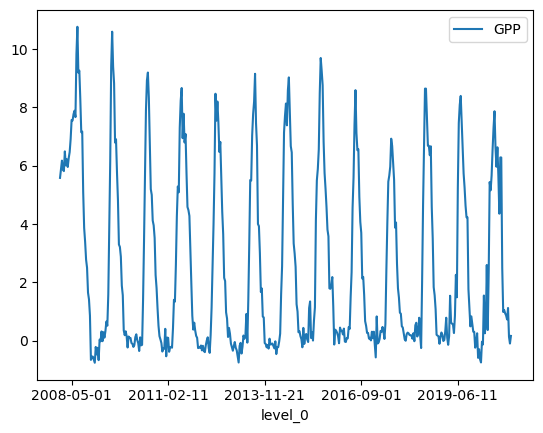

In [69]:
icos[icos.siteid == siteid].plot(x='level_0', y='GPP')

In [12]:
flux['site'] = flux['siteid']

In [44]:
flux[flux.siteid == 'ES-LM2']

,siteid,lat,lon,igbp,source,av_2016,av_2017,av_2018,av_2019,av_2020,...,clc_class,epsg,x,y,xmin,xmax,ymin,ymax,geometry,site
30,ES-LM2,39.934592,-5.775881,SAV,icos_di,1,1,1,0,0,...,['Agro-forestry_areas'],32629,775498.087339,7.126126e+06,775240.0,775740.0,7125880.0,7126380.0,POINT (-5.77588 39.93459),ES-LM2


In [26]:
idx = 45
row = flux.iloc[idx]
row_utm = flux.iloc[[idx]].to_crs(epsg=row.epsg).iloc[0]

logger.info(f'Extracting flux site: {row.site}')
x, y = row_utm.geometry.x, row_utm.geometry.y
d = 250
bounds = (np.array([x - d, y - d, x + d, y + d]) / 20).round() * 20
epsg = row.epsg
tile = row.tile

2023-04-17 12:08:40.095 | INFO     | __main__:<module>:5 - Extracting flux site: SE-Htm


In [30]:
row.epsg

32633

In [33]:
s2grid[s2grid.intersects(row.geometry)]

,geometry,epsg,tile,bounds
8386,"POLYGON ((11.72447 56.80082, 13.52164 56.83506...",32633,33VUC,"(300000.0, 6190200.0, 409800.0, 6300000.0)"
8395,"POLYGON ((13.36044 56.83305, 15.15999 56.84371...",32633,33VVC,"(399960.0, 6190200.0, 509760.0, 6300000.0)"


In [36]:
Polygon.from_bounds(*bounds)

(401400.0, 6217820.0, 401900.0, 6218320.0)

In [32]:
bounds

array([ 401400., 6217820.,  401900., 6218320.])

In [19]:
import satio_pc

In [20]:
s2grid = satio_pc.layers.load('s2grid')

In [21]:
from shapely.geometry import Polygon

In [38]:
tile

geometry    POLYGON ((11.724465390560443 56.80081721393248...
epsg                                                    32633
tile                                                    33VUC
bounds             (300000.0, 6190200.0, 409800.0, 6300000.0)
Name: 8386, dtype: object

In [ ]:
s2grid[s2grid.tile == '33

In [25]:
tile

,geometry,epsg,tile,bounds


In [71]:
flux['site'] = flux['siteid']

In [72]:
def preprocess_flux(ds_dict,
                   clouds_mask,
                   reflectance=True,
                   tmpdir='.'):

    ds10_block = ds_dict[10]
    ds20_block = ds_dict[20]
    scl20_block = clouds_mask

    with tempfile.TemporaryDirectory(prefix='ewc_tmp-', dir=tmpdir) as \
            tmpdirname:

        # download
        logger.info("Loading block data")
        ds10_block = ds10_block.ewc.cache(tmpdirname)

        ds20_block = ds20_block.ewc.cache(tmpdirname)
        scl20_block = scl20_block.ewc.cache(tmpdirname)
        scl10_block = scl20_block.ewc.rescale(scale=2,
                                              order=0)
        scl10_block = scl10_block.ewc.cache(tmpdirname)

        # 10m
        # mask clouds
        ds10_block_masked = ds10_block.ewc.mask(
            scl10_block).ewc.cache(tmpdirname)

        # 20m
        # mask
        ds20_block_masked = ds20_block.ewc.mask(
            scl20_block).ewc.cache(tmpdirname)

        logger.info("Merging 10m and 20m series")
        # merging to 10m cleaned data
        ds20_block_masked_10m = ds20_block_masked.ewc.rescale(scale=2,
                                                              order=1,
                                                              nodata_value=0)
        dsm10 = xr.concat([ds10_block_masked,
                           ds20_block_masked_10m],
                          dim='band')

        if reflectance:
            dsm10 = dsm10.astype(np.float32) / 10000

        dsm10.attrs = ds10_block.attrs

    dsm10 = dsm10.persist()

    return dsm10


def extract_flux(idx):
    from pathlib import Path
    from loguru import logger
    
    flux_nc = Path('flux_nc')
    flux_nc.mkdir(exist_ok=True, parents=True)
    
    plots = Path('flux_plots')
    plots.mkdir(exist_ok=True, parents=True)
    
    row = flux.iloc[idx]
    row_utm = flux.iloc[[idx]].to_crs(epsg=row.epsg).iloc[0]
    
    logger.info(f'Extracting flux site: {row.site}')
    x, y = row_utm.geometry.x, row_utm.geometry.y
    d = 250
    bounds = (np.array([x - d, y - d, x + d, y + d]) / 20).round() * 20
    epsg = row.epsg
    # tile = row.tile
    tile = s2grid[s2grid.intersects(row.geometry)].iloc[0].tile

    start_date = f'2017-01-01'
    end_date = f'2023-01-01'
    max_cloud_cover = settings['l2a']['max_cloud_cover']

    s2_dict = load_l2a(bounds,
                       epsg,
                       tile,
                       start_date,
                       end_date,
                       max_cloud_cover=max_cloud_cover)

    # mask preparation
    mask_settings = settings['l2a']['mask']
    scl = preprocess_scl(s2_dict['scl'],
                         **mask_settings)

    scl20_mask = scl.mask
    scl20_aux = scl.aux

    s2 = preprocess_flux(s2_dict, scl.mask)
    s2 = s2.ewc.cache().persist()

    s2nan = s2.where(s2 > 0, np.nan)
    s2nan = s2.copy(data=s2nan)

    s2_vi = s2nan.ewc.indices(['kndvi', 'evi2'])
    s2_vi_ts = s2_vi.mean(dim=('x', 'y'))
    s2_vi_ts = s2_vi_ts.copy(data=np.nanmean(s2_vi, axis=(-2, -1)))
    s2_vi_ts.shape

    s2_vi_ts.name = 'value'
    s2_vi_ts.to_netcdf(flux_nc / f'flux_{idx:02d}_vi_2017_2023.nc')
    
    for vi in 'kndvi', 'evi2':
        valid_vi = s2_vi_ts.sel(band=vi)
        mask = np.isnan(valid_vi)

        # Drop the values where band is NaN
        valid_vi = valid_vi.where(~mask, drop=True)

        # valid_vi.hvplot(x='time', y='value', kind='scatter')
        plot = valid_vi.hvplot(x='time', y='value')
        # plot.save(plots / f'flux_plot_{idx:02d}_{vi}.png')
        hvplot.save(plot, f'flux_plot_{idx:02d}_{vi}.html')

In [ ]:
for idx in range(flux.shape[0]):
    extract_flux(idx)

In [74]:
extract_flux(41)

2023-04-17 13:29:10.284 | INFO     | __main__:extract_flux:65 - Extracting flux site: IT-SR2
2023-04-17 13:29:27.428 | WARNING  | satio_pc.sentinel2:filter_corrupted_items:57 - Discarding 33 / 662 corrupted products: ['S2B_MSIL2A_20220725T101559_R065_T32TNP_20220727T023828', 'S2A_MSIL2A_20220617T100611_R022_T32TNP_20220619T180419', 'S2A_MSIL2A_20211222T102441_R065_T32TNP_20211223T150025', 'S2A_MSIL2A_20210702T101031_R022_T32TNP_20210703T011623', 'S2B_MSIL2A_20210617T100559_R022_T32TNP_20210623T203001', 'S2A_MSIL2A_20210615T102021_R065_T32TNP_20210623T230300', 'S2A_MSIL2A_20210612T101031_R022_T32TNP_20210623T205052', 'S2B_MSIL2A_20210610T101559_R065_T32TNP_20210623T130703', 'S2A_MSIL2A_20210324T101021_R022_T32TNP_20210324T231451', 'S2A_MSIL2A_20201018T102041_R065_T32TNP_20201019T220804', 'S2A_MSIL2A_20200221T102041_R065_T32TNP_20200927T140835', 'S2A_MSIL2A_20191110T101241_R022_T32TNP_20201003T150152', 'S2A_MSIL2A_20190713T101031_R022_T32TNP_20201005T132209', 'S2B_MSIL2A_20190419T101029_

NameError: name 'a' is not defined

In [54]:
    vi = 'evi2'
    valid_vi = s2_vi_ts.sel(band=vi)
    mask = np.isnan(valid_vi)

    # Drop the values where band is NaN
    valid_vi = valid_vi.where(~mask, drop=True)

    # valid_vi.hvplot(x='time', y='value', kind='scatter')
    # valid_vi.hvplot(x='time', y='value')

/home/jovyan/PlanetaryComputerExamples/personal/satio-pc/satio_pc/indices/__init__.py:153: RuntimeWarning: invalid value encountered in true_divide
  return (arr1 - arr2) / (arr1 + arr2)


In [17]:
import matplotlib.pyplot as plt

In [61]:
s2_vi.interactive.sel(band=pnw.DiscreteSlider, time=pnw.DiscreteSlider).hvplot(aspect=1,
                                                                               colormap='plasma')

/home/jovyan/PlanetaryComputerExamples/personal/satio-pc/satio_pc/indices/__init__.py:153: RuntimeWarning: invalid value encountered in true_divide
  return (arr1 - arr2) / (arr1 + arr2)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/reductions.py:615: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/reductions.py:586: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/jovyan/PlanetaryComputerExamples/personal/satio-pc/satio_pc/indices/__init__.py:153: RuntimeWarning: invalid value encountered in true_divide
  return (arr1 - arr2) / (arr1 + arr2)


In [ ]:
# preprocess s2
tmpdir = tempfile.TemporaryDirectory(prefix='ewc_tmp-', dir=self.block_folder)

# mask preparation
mask_settings = settings['l2a']['mask']
scl = preprocess_scl(s2_dict['scl'],
                     **mask_settings)

scl20_mask = scl.mask
scl20_aux = scl.aux

s2 = preprocess_l2a(s2_dict,
                    scl20_mask,
                    start_date,
                    end_date,
                    composite_freq=settings['l2a']['composite']['freq'],
                    composite_window=settings['l2a']['composite'][
                        'window'],
                    tmpdir=tmpdir.name)

s2_indices = list(RSI_META_S2_HABITAT.keys())

# compute indices
s2_vi = s2.ewc.indices(s2_indices,
                       rsi_meta=RSI_META_S2_HABITAT)

# percentiles sensors and vis
q = [10, 25, 50, 75, 90]
ps = [s.ewc.percentile(q, name_prefix='s2') for s in (s2, s2_vi)]

# fix time to same timestamp (only 1) to avoid concat issues
# (different compositing settings for s2 and s1)
for p in ps:
    p['time'] = ps[0].time

# ndvi 12 timestamps
ndvi_ts = s2_vi.sel(band=['ndvi'])
ndvi_ts = ndvi_ts.ewc.composite(freq=30,
                                window=30,
                                start=start_date,
                                end=end_date)

ndvi_ts = xr.DataArray(da.transpose(ndvi_ts.data, (1, 0, 2, 3)),
                       dims=ps[0].dims,
                       coords={'time': ps[0].time,
                               'band': [f's2-ndvi-ts{i}'
                                        for i in range(1, 13)],
                               'y': ps[0].y,
                               'x': ps[0].x},
                       attrs=ps[0].attrs)

# scl aux 10m
scl10_aux = scl20_aux.ewc.rescale(scale=2, order=1)
scl10_aux['time'] = ps[0].time

final = xr.concat(ps + [ndvi_ts, scl10_aux], dim='band')
final.name = 'satio-features-s2'

logger.info("Computing features stack")
final = final.persist()
final = final.squeeze()

epsg = tile_to_epsg(tile)
crs = CRS.from_epsg(epsg)
final = final.rio.write_crs(crs)
final_ds = final.to_dataset('band')

output_folder = Path(self.block_folder)
fn = output_folder / \
    f'{final.name}_{tile}_{block.block_id:03d}_{year}.tif'
logger.info(f"Saving features stack to {fn}")
final_ds.rio.to_raster(fn,
                       windowed=False,
                       tiled=True,
                       compress='deflate',
                       predictor=3,
                       zlevel=4)